In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

# Careful with these: basic_viewing should be replaced soon
from basic_viewing import events as evt
# from basic_viewing.structure import kwik_functions as kwkf
# from basic_viewing.structure.core import h5_functions as kwdf

from swissknife.bci.core import kwik_functions as kwkf
from swissknife.bci.core.file import h5_functions as kwdf 
from swissknife.bci.core import expstruct as et
from swissknife.bci import events
from swissknife.h5tools import h5tools as h5
from swissknife.streamtools import streams as st
from swissknife.streamtools import spectral as sp
from swissknife.streamtools import temporal as tp


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)



logger.debug('All modules loaded')

Computer: passaro


In [2]:
def list_sum(a_list):
    s = a_list[0]
    for new_s in a_list[1:]:
        s+=new_s
    return s


def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []
    bad_frames = []
    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        try:
            one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                           s_f,
                                           dtype=np.float),
                                 np.array(chan_list),
                                 [start, start + span])
            frames.append(one_frame)
        except AssertionError:
            logger.warning('Frame out of bounds [{0}:{1}]'.format(start, start+span))
            bad_frames.append(i_start)
    return frames, np.delete(starts, bad_frames), np.delete(recs_list, bad_frames)

def identity(x):
    return x

def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float)
        starts_from_rec = stars[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts, window, lambda x: x)
        all_frames.append[rec_frames]
    return all_frames

def gather_all_frames(bird_id, sess_id, viz_set, stim_name='bos_tag'):
    exp_pars = et.get_parameters(bird_id, sess_id)
    f_n = et.file_names(bird, sess)


    
    
    stim_id = et.stim_id(exp_pars, stim_name)
    stim_file_path = et.file_path(f_n, 'ss', 'sng')
    with h5py.File(stim_file_path, 'r') as stim_file:
        stim = evt.Song(stim_id, stim_file)    
        starts = stim.get_start()
        recs = stim.get_rec()

    stimm_path = os.path.join(f_n['folders']['stim'], viz_set['stim_sess'], 
                      exp_par['search_motiff']['motiff_patterns'][stim_name])
    stim_chunk = st.Chunk(st.WavData2(m_path))
    
    before = viz_set['before_samp']
    after = viz_set['after_samp']
    with et.open_kwd(bird_id, sess_id) as kwd_f:
        v_frames, v_starts, v_recs = collect_frames(starts-before, before+after+stim_chunk.samples, 
                            s_f, 
                            kwd_f, recs, viz_set['channels'])
    
    return v_frames, v_starts, v_recs, stim_chunk


In [3]:
# bird and session

bird = 'z030'
sess = 'day-anesth_surface_2016-12-16_3'
stim_sess = '001'


spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [1, 1250]

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt
    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = et.get_stims_dict(bird, sess)

print pattern_names

{'bos_rev_tag': 'bos_rev_tag.wav', 'con_syn_tag': 'bos_syn_tag.wav', 'bos_tag': 'bos_tag.wav'}


989.833333333
fcut_plot 10000


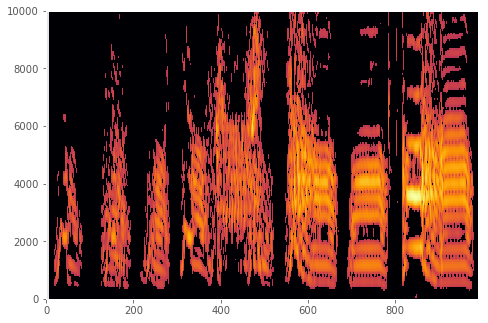

In [5]:
reload(sp)
#pattern
m_name = 'bos_tag'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m_id = et.stim_id(exp_par, m_name)

m = evt.Song(m_id, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

(<matplotlib.figure.Figure at 0x7f09fad84f10>,
 <matplotlib.axes._axes.Axes at 0x7f09fad31e50>)

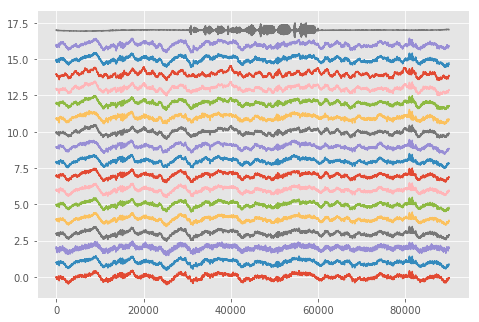

In [6]:
reload(st)
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

lfp_spectro_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 150,
                 'db_cut': 0.000065 }

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 30
neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
#neural_chans = np.array(exp_par['channel_config']['neural'])
bad_chans = np.array([0, 2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31])
neural_chans = np.delete(neural_chans, bad_chans)

before = 30000
after = 30000
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)

lfp_frame.plot()

2017-05-26 10:06:33,696 root         INFO     Collecting 75 frames...
2017-05-26 10:06:33,698 root         INFO     Frame 0 ...
2017-05-26 10:06:35,492 root         INFO     Frame 10 ...
2017-05-26 10:06:37,459 root         INFO     Frame 20 ...
2017-05-26 10:06:39,519 root         INFO     Frame 30 ...
2017-05-26 10:06:40,963 root         INFO     Frame 40 ...
2017-05-26 10:06:42,971 root         INFO     Frame 50 ...
2017-05-26 10:06:44,482 root         INFO     Frame 60 ...
2017-05-26 10:06:45,940 root         INFO     Frame 70 ...
2017-05-26 10:06:47,211 root         WARNING  Frame out of bounds [32148022:32297973]


4993.86666667
fcut_plot 6.90775527898
4993.86666667
fcut_plot 6.90775527898


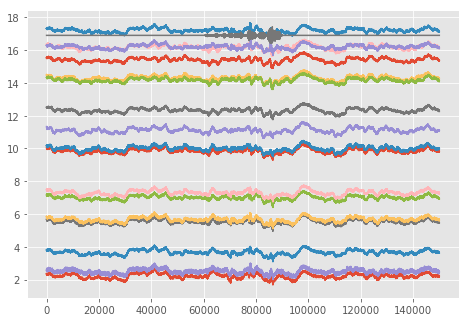

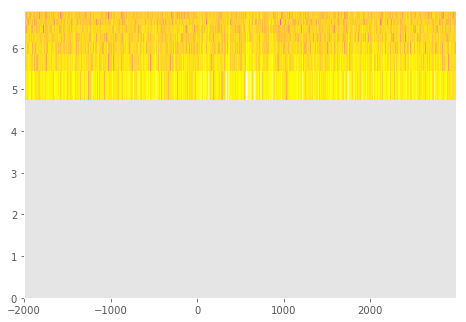

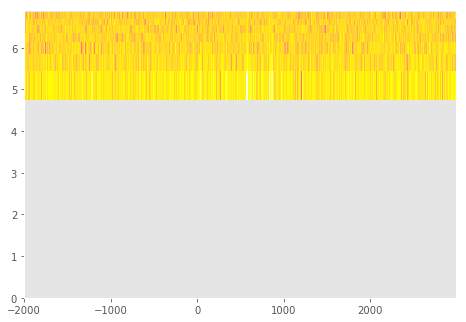

In [12]:
sess = 'day-anesth_surface_2016-12-16_4'
stim_name = 'bos_tag'
lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': filter_pars, 
          'before_samp': 60000,
          'after_samp': 60000,
          'channels': neural_chans}

fn = et.file_names(bird, sess)

all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name=stim_name)
#st.list_apply_filter(all_frames, st.car, np.arange(neural_chans.size-1))

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_car_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
chan = 2
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

In [13]:
fr = all_frames[0]

In [14]:
fr.chan_list

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 29, 30,
       32])

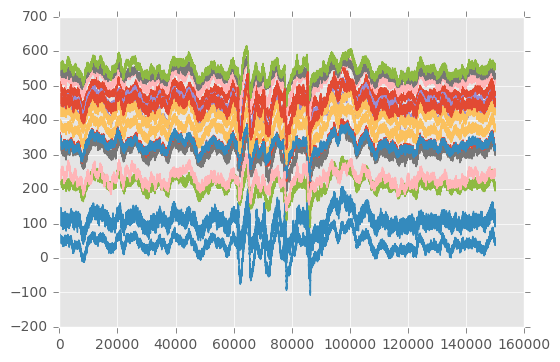

In [12]:
plt.plot(all_avg[:,2:-1])

2017-01-11 08:53:55,094 root         INFO     Collecting 75 frames...
2017-01-11 08:53:55,096 root         INFO     Frame 0 ...
2017-01-11 08:53:55,393 root         INFO     Frame 10 ...
2017-01-11 08:53:55,624 root         INFO     Frame 20 ...
2017-01-11 08:53:55,847 root         INFO     Frame 30 ...
2017-01-11 08:53:56,069 root         INFO     Frame 40 ...
2017-01-11 08:53:56,281 root         INFO     Frame 50 ...
2017-01-11 08:53:56,472 root         INFO     Frame 60 ...
2017-01-11 08:53:56,663 root         INFO     Frame 70 ...


4993.86666667
fcut_plot 6.90775527898
4993.86666667
fcut_plot 6.90775527898


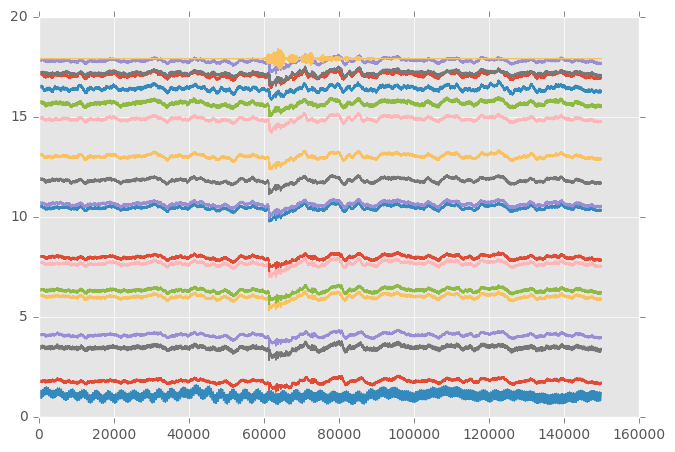

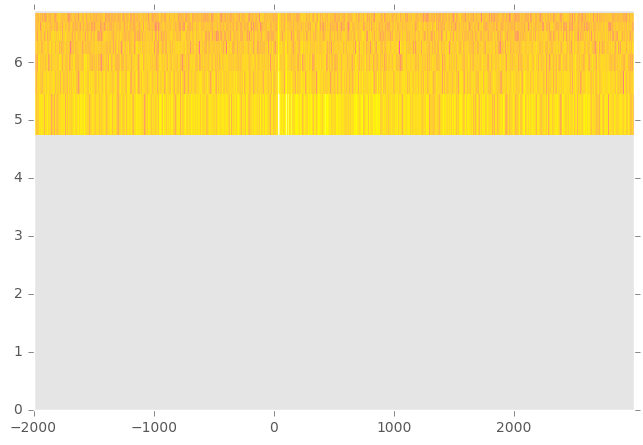

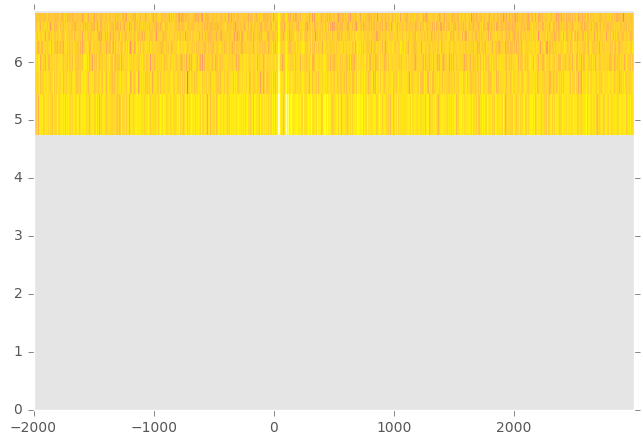

In [7]:
sess = 'day-anesth_surface_2016-12-16_3'
stim_name = 'bos_rev_tag'
lfp_spectro_pars={'n_window': 256*1,
                  'n_overlap': 256*1-8,
                 'sigma': 30*15*4,
                 'f_cut': 1000,
                 'db_cut': 0.}

viz_set = {'stim_sess': '001', 
          'filter_pars': filter_pars, 
          'before_samp': 60000,
          'after_samp': 60000,
          'channels': neural_chans}

fn = et.file_names(bird, sess)

all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name=stim_name)

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
chan = 2
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

In [14]:
all_frames[0]

array([  87.,   93.,  130., ...,  106.,  105.,  133.])

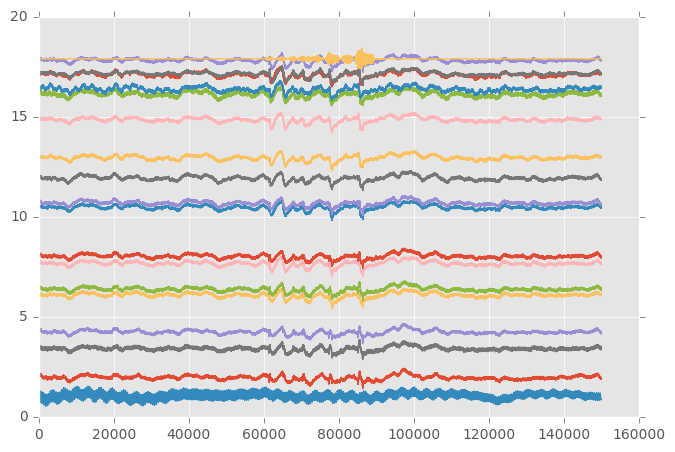

In [48]:
stim_name = 'bos_tag'
st.plot_array(all_avg)
fig_name='fig_avg_traces_{0}_{1}.pdf'.format(sess, stim_name)
plt.savefig(os.path.join(fn['folders']['ss'], fig_name))

2017-01-10 13:49:29,912 root         INFO     Collecting 75 frames...
2017-01-10 13:49:29,913 root         INFO     Frame 0 ...
2017-01-10 13:49:31,789 root         INFO     Frame 10 ...
2017-01-10 13:49:33,070 root         INFO     Frame 20 ...
2017-01-10 13:49:34,357 root         INFO     Frame 30 ...
2017-01-10 13:49:35,859 root         INFO     Frame 40 ...
2017-01-10 13:49:37,221 root         INFO     Frame 50 ...
2017-01-10 13:49:38,511 root         INFO     Frame 60 ...
2017-01-10 13:49:39,690 root         INFO     Frame 70 ...


4993.86666667
fcut_plot 6.90775527898


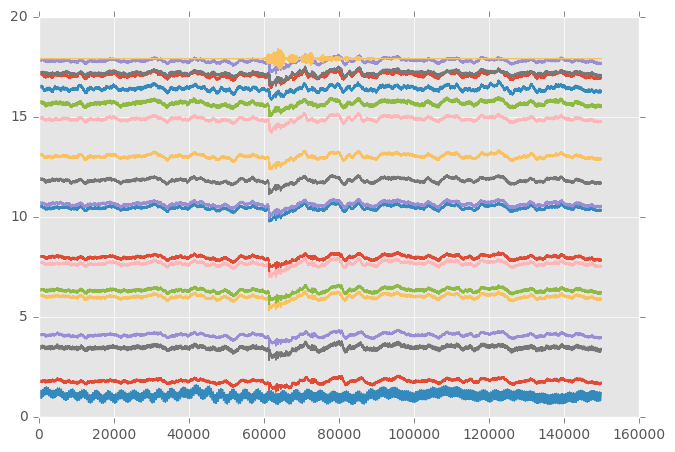

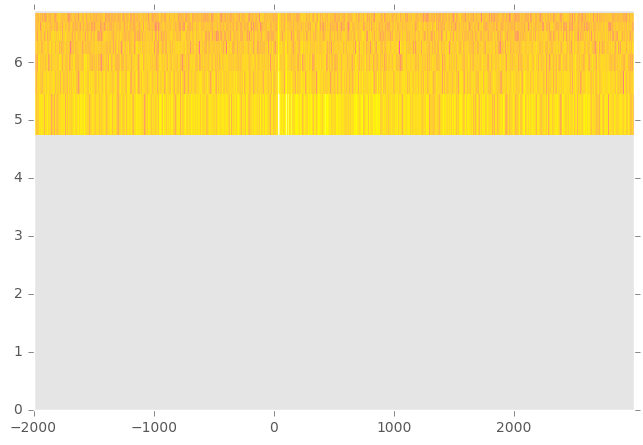

In [42]:
all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name='bos_rev_tag')

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)
chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')

2017-01-10 13:46:39,464 root         INFO     Collecting 70 frames...
2017-01-10 13:46:39,466 root         INFO     Frame 0 ...
2017-01-10 13:46:40,974 root         INFO     Frame 10 ...
2017-01-10 13:46:42,287 root         INFO     Frame 20 ...
2017-01-10 13:46:43,514 root         INFO     Frame 30 ...
2017-01-10 13:46:45,058 root         INFO     Frame 40 ...
2017-01-10 13:46:46,479 root         INFO     Frame 50 ...
2017-01-10 13:46:47,457 root         INFO     Frame 60 ...


(<matplotlib.figure.Figure at 0x7fd9db7dc650>,
 <matplotlib.axes._axes.Axes at 0x7fd9db30fd90>)

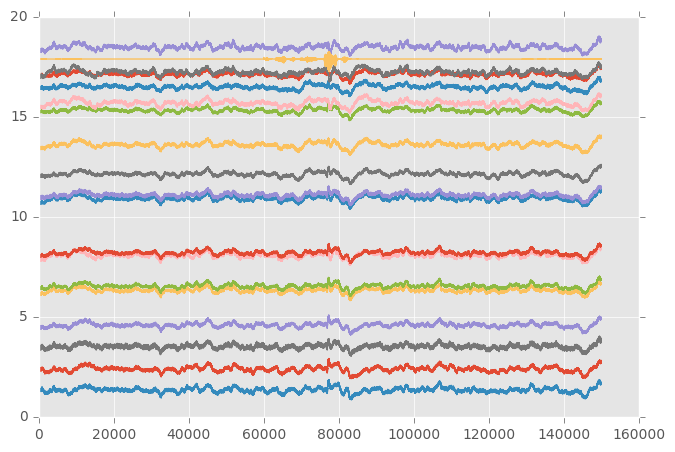

In [37]:
all_frames, all_starts, all_recs, stm_chunk = gather_all_frames(bird, sess, viz_set, stim_name='con_syn_tag')

all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)

2017-01-10 10:52:27,640 root         INFO     Collecting 70 frames...
2017-01-10 10:52:27,642 root         INFO     Frame 0 ...
2017-01-10 10:52:27,976 root         INFO     Frame 10 ...
2017-01-10 10:52:28,146 root         INFO     Frame 20 ...
2017-01-10 10:52:28,316 root         INFO     Frame 30 ...
2017-01-10 10:52:28,536 root         INFO     Frame 40 ...
2017-01-10 10:52:28,728 root         INFO     Frame 50 ...
2017-01-10 10:52:28,913 root         INFO     Frame 60 ...


(<matplotlib.figure.Figure at 0x7fd9dbc58b10>,
 <matplotlib.axes._axes.Axes at 0x7fd9d1d3ab90>)

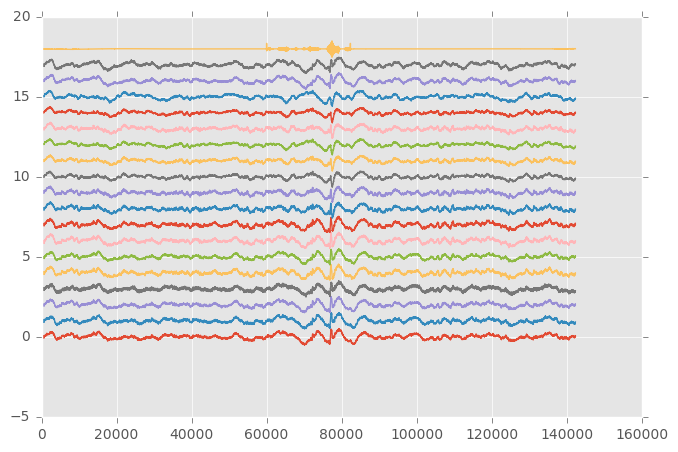

In [10]:
logger.setLevel(logging.INFO)
before = 60000
after = 60000

all_frames, all_starts, all_recs = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

nothing = st.list_apply_filter(all_frames, sp.apply_butter_bandpass, filter_pars)

# average across all frames
reload(st)
all_avg = st.sum_frames(all_frames)
st.plot_array(all_avg)

4198.13333333
fcut_plot 5.70378247466


/mnt/cube/earneodo/repos/swissknife/streamtools/spectral.py:78: RuntimeWarning: divide by zero encountered in log
  f_plot = np.log(f) if log_f else f


NameError: name 'first_avg' is not defined

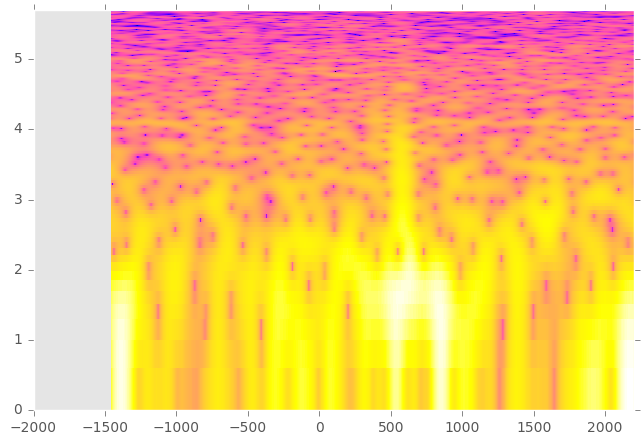

In [11]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')


3452.0
fcut_plot 5.70378247466


(<matplotlib.figure.Figure at 0x7fa479e066d0>,
 <matplotlib.axes._axes.Axes at 0x7fa48bc79850>)

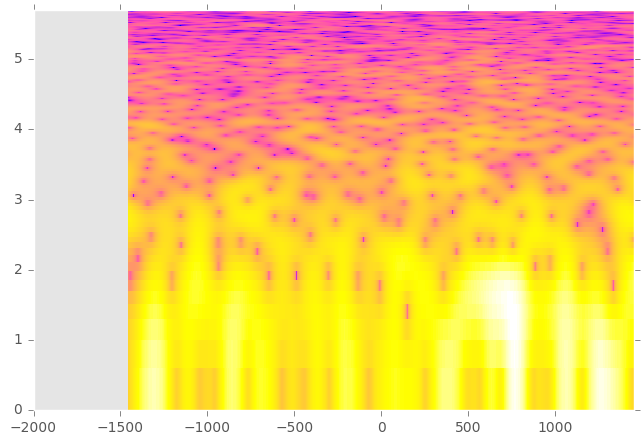

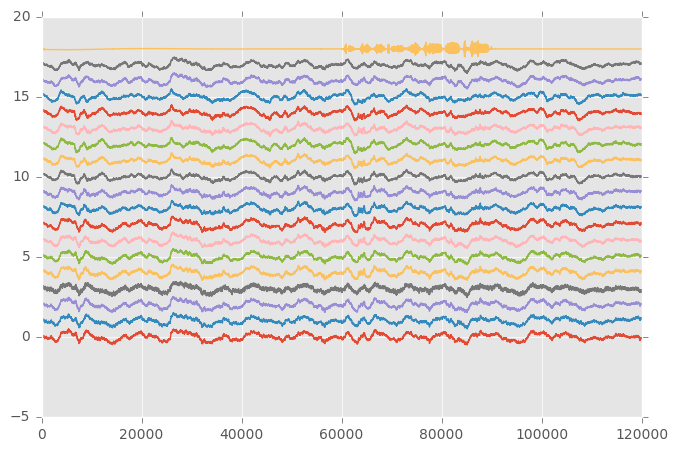

In [99]:
lfp_spectro_pars={'n_window': 4096*8,
                  'n_overlap': 4096*8-8,
                 'sigma': 30*15*4,
                 'f_cut': 300,
                 'db_cut': 0.}

chan = 8
spec_chan = sp.Spectrogram(all_avg[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=2000, log_f=True, cmap='gnuplot2')
first_avg.plot()

In [31]:
f_cut = 70
n_window = 2048*8
n_overlap = n_window-8

response_spectrogram = spectrogram(first_avg.data[:, 8], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*30), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

NameError: name 'sigma' is not defined

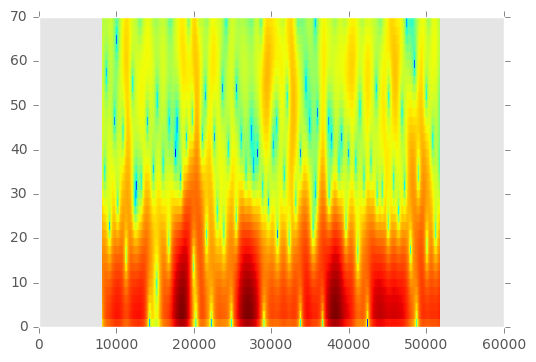

In [14]:
response_spectrogram = spectrogram(lfp_frame.data[:, 6], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [26]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


spectr_stack = []

for ch in range(n_chans):
    print ch
    for i_trial in range(n_trials):
        start = starts[i_trial]
        one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
        lfp[:, i_trial, :] = one_frame.data
        this_spectrogram = spectrogram(one_frame.data[:, ch], s_f, 
                                      nperseg = n_window, 
                                      noverlap= n_overlap, 
                                      window = sg.gaussian(n_window, sigma*50), 
                                      scaling='density')
        spectr[i_trial, :, :] = (this_spectrogram[2])
    
    spectr_stack.append(spectr)
    
#all_spectra = np.stack(spectr_stack, axis=0)

0
1
2
3
4
5
6
7


MemoryError: 

In [66]:
all_spectra = np.stack(spectr_stack, axis=0)

MemoryError: 

In [52]:
spectr_stack[0].shape

(74, 8193, 3890)

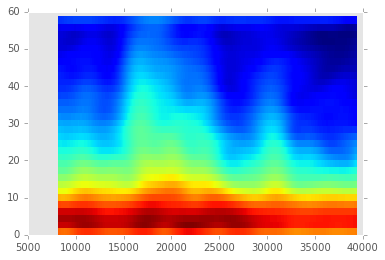

In [28]:
f_cut = 60
ch = 2
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

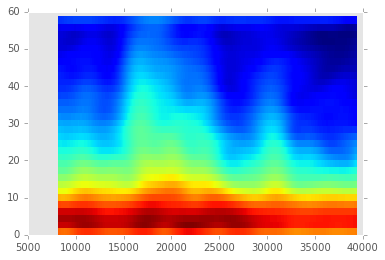

In [34]:
f_cut = 60
ch = 4
mean_spectr = np.mean(spectr_stack[ch], axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

In [17]:
plt.figure(1)
plt.subplot(311)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(312)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(313)
plt.plot(lfp[:,4,0])
plt.show()
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

(49, 2049, 3680)

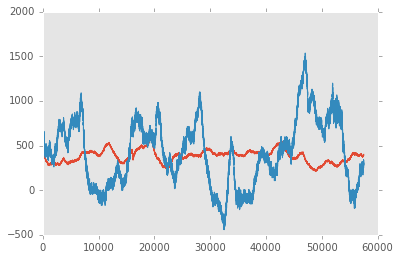

In [82]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.plot(lfp[:,4,1])

f_cut = 150
n_window = 2048
n_overlap = n_window - 1
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

song_file_path = et.file_path(fn, 'ss', 'sng')
fig_name = os.path.join(fn['folders']['ss'], 'trial_vs_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

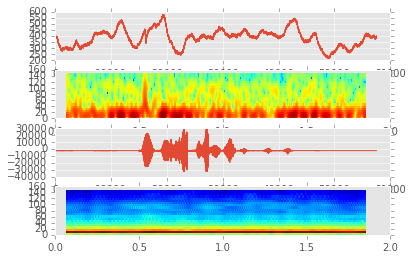

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()


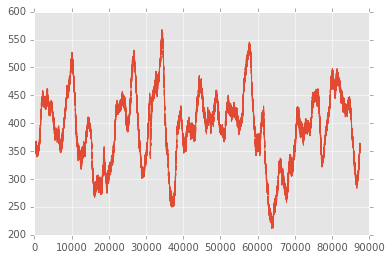

In [96]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))

In [24]:
n_starts = m_starts.size
n_chans = neural_chans.size
n_samples = before + after + m_chunk.samples

sup_lfp = np.empty([n_chans, n_starts, n_samples], dtype=np.float)

for rec in np.unique(recs):
    dset = h5.get_data_set(kwd_file, rec)
    h5d = H5Data(dset, s_f, dtype=np.float)
    this_rec = np.where(recs==rec)[0]
    print this_rec
    for i_trial, start in zip(this_rec, starts[this_rec][:-1]):
        print i_trial
        sup_lfp[:, i_trial, :] = h5d.get_chunk(start-before, start + m_chunk.samples + after, neural_chans).T


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


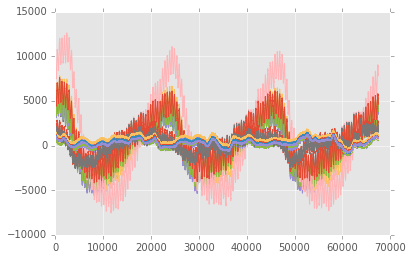

In [10]:
plt.plot(sup_lfp[:,7,:].T)

In [37]:
np.unique(recs)

array([0])

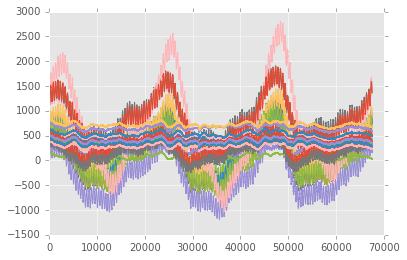

In [11]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape
plt.plot(trial_mean.T)

In [15]:
trial_mean = np.mean(sup_lfp, axis=1)
trial_mean.shape

(31, 67535)

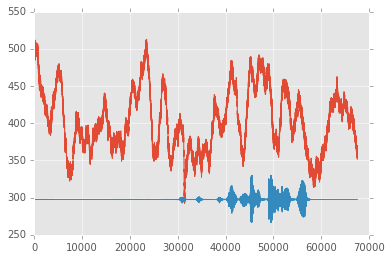

In [38]:
plt.plot(trial_mean[30,:])
plt.plot(lfp_frame.data[:,31]/1000. + 300)

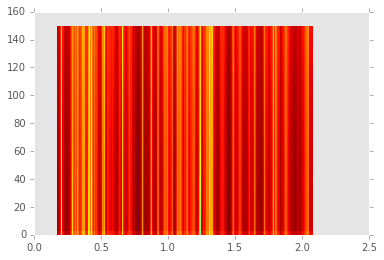

In [46]:
f_cut = 150
n_window = 1024*10
n_overlap = n_window - 1
response_spectrogram = spectrogram(trial_mean[30,:], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [ ]:
scipy.io.wavfile.write(filename, rate, data)

In [49]:
wavfile.write('one_channel.wav', 30000, trial_mean[30,:].astype(np.int16))


In [48]:
pwd

u'/mnt/cube/earneodo/repos/ephysflow'